In [1]:
from math import pi
import math 
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
import control.matlab as ml

The table coefficients(Table 12.3) were taken from [1], as well as the method of calculations.

# Sallen- Key Equal Component Design

The calculator below is not as automated as the Unity Gain Calculator. The equal component design increased the gain to achieve the correct filter response, but this quickly leads to stages encountering clipping of the input signal. The gain adjustment function allows the user to tweak and adjust the gain of each stage manually. This will result in a voltage divider that will replace the input resistor.

In [2]:
class FilterCalculator:
    def __init__(self):
        pass
    
    def tableCalculation(DesignFrequency, DecimalPlaceAccuracy, Type, Response, Order, Tolerance, Graphing = False, Equations = False, Poles = False, Zeros = False):
        """
        A function that calculates the resulting filter response and other parameters* using Sallen-Key Equal component design
         according to [1] for the desired frequency, type and response.
        An optimisation function determines the best practical resistor value based on the amount of error it will cause in the physical circuit. The capacitors are not optimal values.
        
        Parameters:
        -----------
        DesignFrequency: int or float, required
           The desired design frequency in Hz
        
        DecimalPlaceAccuracy: int
            How accurate the mathematical calculations should be. 
                Bug: Error will occur when the decimal accuracy is too large because it cannot find a solution
        
        Type: str, required
            The type of filter to be implemented (chebyshev0_1; chebyshev1; butterworth; bessel)
                Note: Chebyshev0_1 - Type 1 
                      Chebyshev1 - Type 2
                      
        Response: str, required
            High pass or Low pass filter
        
        Order: int, required
            The order of the filter to be implemented (2,4,6,8)
        
        Tolerance: int, required
            The amount of resistor tolerance allowed in a design (1%, 5% and 10%)
        
        Graphing: bool, optional
            Plots the response of the graphs in the cascaded stages
            
        Equations: bool, optional
            Control library calculates and displays the transfer function of the filter
        
        Poles: bool, optional
            Control library calculates the poles of the system 
        
        Zeros: bool, optional
            Control library calculates the zeros of the system
        
        Returns:
        --------
        result: list[list[R, R_a, R_b], list[C]]
            A list containing the values of interest in practical+threoretcial form for the resistors
        """ 
        # NOTE: These are restriction parameters that can be used to limit allowable component values
        capacitance_lower = (2.2 * (10 ** -12))
        capacitance_upper = (1 * (10 ** -8))
        resistance_lower = (1 * (10 ** 3))
        resistance_upper = (2.7 * (10 ** 6))
        
        # design frequency
        fc = DesignFrequency
        
        r_percentage0 = 1
        r_percentage1 = 1
        r_percentage2 = 1
        r_percentage3 = 1
        r_percentage4 = 1
        
        w_0_0 = 0
        Q_0_0 = 0
        w_0_1 = 0
        Q_0_1 = 0
        w_0_2 = 0
        Q_0_2 = 0
        w_0_3 = 0
        Q_0_3 = 0
        w_0_4 = 0
        Q_0_4 = 0

        store0 = []
        store1 = []
        store2 = []
        store3 = []
        store4 = []

        result = []
        
        gain = []
        
        # Percentage tolerance selection
        def RandCVals(tolerance):
            
            # https://www.electronics-notes.com/articles/electronic_components/resistors/standard-resistor-values-e-series-e3-e6-e12-e24-e48-e96.php
            #1 percent
            if (tolerance == 0.01):
                ce12 = [[
                        100,102,105,107,110,113,115,118,121,124,127,130,133,137,140,143,147,150,154,158,162,165,169,174,
                        178,182,187,191,196,200,205,210,215,221,226,232,237,243,249,255,261,267,274,280,287,294,301,309,
                        316,324,332,340,348,357,365,374,383,392,402,412,422,432,442,453,464,475,487,499,511,523,536,549,
                        562,576,590,604,619,634,649,665,681,698,715,732,750,768,787,806,825,845,866,887,909,931,953,976
                        ],[10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 = [[
                        100,102,105,107,110,113,115,118,121,124,127,130,133,137,140,143,147,150,154,158,162,165,169,174,
                        178,182,187,191,196,200,205,210,215,221,226,232,237,243,249,255,261,267,274,280,287,294,301,309,
                        316,324,332,340,348,357,365,374,383,392,402,412,422,432,442,453,464,475,487,499,511,523,536,549,
                        562,576,590,604,619,634,649,665,681,698,715,732,750,768,787,806,825,845,866,887,909,931,953,976]
                        ,[10**(1), 10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            # 5 percent
            elif (tolerance == 0.05):
                ce12 = [[10, 12, 15, 18, 22, 27, 33, 39, 47, 56, 68, 82],
                         [10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 =  [[10, 12, 15, 18, 22, 27, 33, 39, 47, 56, 68, 82], 
                        [10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            # 10 percent
            elif (tolerance == 0.1):
                ce12 = [[10, 15, 22, 33, 47, 68],
                         [10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 = [[10, 15, 22, 33, 47, 68], 
                        [10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            return ce12, re6
        
                           
        c_e12, r_e6 = RandCVals(Tolerance)
        
        
        # Change these values depending on the table
        # Butterworth
        if (Order == 2) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1]
            Q_0_table = [0.707]
    
        elif (Order == 4) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1]
            Q_0_table = [0.541, 1.306]
    
        elif (Order == 6) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1]
            Q_0_table = [0.518, 0.707, 1.932]
        
        elif (Order == 8) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1,1]
            Q_0_table = [0.510,0.601,0.900,2.563]
        
        elif (Order == 10) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1,1,1]
            Q_0_table = [0.506,0.561,0.707,1.101,3.196]
    
        # Bessel
        elif (Order == 2) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.274]
            Q_0_table = [0.577]
    
        elif (Order == 4) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.419,1.591]
            Q_0_table = [0.522,0.806]
    
        elif (Order == 6) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.606,1.691,1.907]
            Q_0_table = [0.510,0.611,1.023]
        
        elif (Order == 8) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.784,1.838,1.958,2.196]
            Q_0_table = [0.506,0.560,0.711,1.226]
        
        elif (Order == 10) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.949,1.987,2.068,2.211,2.485]
            Q_0_table = [0.504,0.538,0.620,0.810,1.415]

        # 0.1dB Ripple
        elif (Order == 2) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.820]
            Q_0_table = [0.767]
        
        elif (Order == 4) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.153,0.789]
            Q_0_table = [2.183,0.619]
            
        elif (Order == 6) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.063,0.834,0.513]
            Q_0_table = [4.633,1.332,0.599]
        
        elif (Order == 8) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.034,0.894,0.645,0.382]
            Q_0_table = [8.082,2.453,1.183,0.593]
        
        elif (Order == 10) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.022,0.928,0.754,0.524,0.304]
            Q_0_table = [12.522,3.921,2.044,1.127,0.590]
         
        # 1dB Ripple
        elif (Order == 2) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [1.050]
            Q_0_table = [0.957]
        
        elif (Order == 4) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.993,0.529]
            Q_0_table = [3.559,0.785]
            
        elif (Order == 6) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.995,0.747,0.353]
            Q_0_table = [8.004,2.198,0.761]
        
        elif (Order == 8) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.997,0.851,0.584,0.265]
            Q_0_table = [14.240,4.266,1.956,0.753]
            
        elif (Order == 10) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.998,0.902,0.721,0.476,0.212]
            Q_0_table = [22.263,6.937,3.561,1.864,0.749]
            
        # Design method according to filter response
        
        if (str.upper(Response) == "LOWPASS"):
            def h_lpf_calculations(val, f_c, f_table, c, q, r_a):
                f0 = f_c * f_table
                w0 = 2 * pi * f0
                k = 3 - 1 / q
                r = 1 / (c * w0)
                r_b = (k - 1) * r_a
                return f_c, f0, q, w0, c, k, r, r_a, r_b
            
        elif (str.upper(Response) == "HIGHPASS"):
            def h_lpf_calculations(val, f_c, f_table, c, q, r_a):
                f0 = f_c / f_table
                w0 = 2 * pi * f0
                k = 3 - 1 / q
                r = 1 / (c * w0)
                r_b = (k - 1) * r_a
                return f_c, f0, q, w0, c, k, r, r_a, r_b

        
        #re6 is the main priority 
        nearestRarray = []
        for l in range(0, len(r_e6[0])):
            for m in range(0, len(r_e6[1])):
                if (r_e6[0][l] * r_e6[1][m] <= resistance_upper and (r_e6[0][l] * r_e6[1][m] >= resistance_lower)):
                    nearestRarray.append(r_e6[0][l] * r_e6[1][m])
        
        i = 0
        j = 0
        k = 0
        
        for k in range(0, len(f_0_table)):
            for i in range(0, len(c_e12[0])):
                for j in range(0, len(c_e12[1])):
                    if ((c_e12[1][j] * c_e12[0][i]) >= capacitance_lower and (c_e12[0][j] * c_e12[1][j]) <= capacitance_upper):
                        for l in range(0, len(r_e6[0])):
                            for m in range(0, len(r_e6[1])):
                                if (r_e6[0][l] * r_e6[1][m] <= resistance_upper and (r_e6[0][l] * r_e6[1][m] >= resistance_lower)):

                                    F_c, F0, Q, W, C, K, R, R_a, R_b = h_lpf_calculations(k, fc, f_0_table[k],(c_e12[1][j] * c_e12[0][i]),Q_0_table[k], 10000)
                                    
                                    # Second Order
                                    if (Order >= 2):
                                        if ((k == 0) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage0) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage0 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store0.clear()
                                            store0 = [F_c, F0, Q, W, C, K, R, R_a, R_b]
                                            
                                    # Fourth Order
                                    if (Order >= 4):
                                        if ((k == 1) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage1) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage1 =   round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store1.clear()
                                            store1 = [F_c, F0, Q, W, C, K, R, R_a, R_b]
                                    
                                    # Sixth Order
                                    if (Order >= 6):
                                        if ((k == 2) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage2) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage2 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store2.clear()
                                            store2 = [F_c, F0, Q, W, C, K, R, R_a, R_b]

                                    # Eighth Order
                                    if (Order >= 8):
                                        if ((k == 3) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage3) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage3 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) 
                                            store3.clear()
                                            store3 = [F_c, F0, Q, W, C, K, R, R_a, R_b]
                                    
                                    # Tenth Order
                                    if (Order >= 10):
                                        if ((k == 4) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage4) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage4 = round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) 
                                            store4.clear()
                                            store4 = [F_c, F0, Q, W, C, K, R, R_a, R_b]
        
        def print_values(count, arr, resp, typ, nearArr):
            # Find the nearest real value array
            def find_nearest(arrIn, value):
                arrIn = np.asarray(arrIn)
                idx = (np.abs(arrIn - value)).argmin()
                return arrIn[idx]
            
            print('--------------------------------- \n')
            if count==0:
                print(resp)    
                print(typ)
            print('Stage : ' + str(count) + '\n')
            print('Natural frequency(f_0):' + str(arr[0]) + '\n')
            print('Cut off frequency(f_c):' + str(arr[1]) + '\n')
            print('Angular Frequency(w_o):' + str(arr[3]) + '\n')
            print('Quality Factor(Q):' + str(arr[2]) + '\n')
            print('Capacitance value chosen:' + str(arr[4]) + '\n')
            print('Gain:' + str(arr[5]) + '\n')
            print('Resitance(R):' + str(arr[6]) + ' /Practical Value: ' + str(find_nearest(nearArr,arr[6])) +'\n')
            print('R_a:' + str(arr[7]) + '\n')
            print('R_b:' + str(arr[8]) + ' /Practical Value: ' + str(find_nearest(nearArr,arr[8])) +'\n')
            print('---------------------------------' + '\n')
            print('\n')
            return [[find_nearest(nearArr,arr[6]), find_nearest(nearArr,arr[8]), find_nearest(nearArr,arr[8])],[arr[6], arr[8]], arr[4]]
        
        # Print the values
        if (Order >= 2):
            result.append(print_values(0, store0, str.upper(Response), str.upper(Type), nearestRarray))
            gain.append(store0[5])

        if (Order >= 4):
            result.append(print_values(1, store1, str.upper(Response), str.upper(Type), nearestRarray))
            gain.append(store1[5])
            
        if (Order >= 6):
            result.append(print_values(2, store2, str.upper(Response), str.upper(Type), nearestRarray))
            gain.append(store2[5])
            
        if (Order >= 8):
            result.append(print_values(3, store3, str.upper(Response), str.upper(Type), nearestRarray))
            gain.append(store3[5])
        
        if (Order >= 10):           
            result.append(print_values(4, store4, str.upper(Response), str.upper(Type), nearestRarray))
            gain.append(store4[5])
            
        # Graphing    
        if (Graphing == True):
            
            s = ml.tf('s')
            
            if (Order>=2):
                w_0_0 = (store0[3])
                Q_0_0 = 1/store0[2]
            if (Order>=4):
                w_0_1 = (store1[3])
                Q_0_1 = 1/store1[2]
            if (Order>=6):
                w_0_2 = (store2[3])
                Q_0_2 = 1/store2[2]
            if (Order>=8):
                w_0_3 = (store3[3])
                Q_0_3 = 1/store3[2]
            if (Order>=10):
                w_0_4 = (store4[3])
                Q_0_4 = 1/store4[2]
                
            if (str.upper(Response) == "LOWPASS"):
                
                if (Order>=2):
                    H  = gain[0]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_0 ) **2 ) + ( s *Q_0_0 ) / w_0_0 ) )
                    mag, phase, w = ml.bode(H)
                    Z = H
                if (Order>=4):
                    G = gain[1]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_1 ) **2 ) + ( s *Q_0_1 ) / w_0_1 ) )
                    mag1, phase1, w1 = ml.bode(G)
                    Z = H*G
                if (Order>=6):
                    M = gain[2]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_2 ) **2 ) + ( s *Q_0_2 ) / w_0_2 ) )
                    mag2, phase2, w2 = ml.bode(M)
                    Z = H*G*M
                if (Order>=8):
                    N = gain[3]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_3 ) **2 ) + ( s *Q_0_3 ) / w_0_3 ) )
                    mag3, phase3, w3 = ml.bode(N)
                    Z = H*G*M*N
                if (Order>=10):
                    O = gain[3]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_4 ) **2 ) + ( s *Q_0_4 ) / w_0_4 ) )
                    mag4, phase4, w4 = ml.bode(O)
                    Z = H*G*M*N*O
                    
                plt.show()
                
                magNew,phaseNewe,wNew = ml.bode(Z)
                plt.show()
                
            elif (str.upper(Response) == "HIGHPASS"):
                
                if (Order>=2):
                    H  = gain[0]*( ( (s / w_0_0 ) **2 ) / ( 1 + ( ( s ) **2 ) / ( ( w_0_0 ) **2 ) + ( s *Q_0_0 ) / w_0_0 ) )
                    mag, phase, w = ml.bode(H)
                    Z = H
                if (Order>=4):
                    G = gain[1]*( ( (s / w_0_1 ) **2 ) / ( 1 + ( ( s ) **2 ) / ( ( w_0_1 ) **2 ) + ( s *Q_0_1 ) / w_0_1 ) )
                    mag1, phase1, w1 = ml.bode(G)
                    Z = H*G
                if (Order>=6):
                    M = gain[2]*( ( (s / w_0_2 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_2 ) **2 ) + ( s *Q_0_2 ) / w_0_2 ) )
                    mag2, phase2, w2 = ml.bode(M)
                    Z = H*G*M
                if (Order>=8):
                    N = gain[3]*( ( (s / w_0_3 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_3 ) **2 ) + ( s *Q_0_3 ) / w_0_3 ) )
                    mag3, phase3, w3 = ml.bode(N)
                    Z = H*G*M*N
                if (Order>=10):
                    O = gain[3]*( ( (s / w_0_4 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_4 ) **2 ) + ( s *Q_0_4 ) / w_0_4 ) )
                    mag4, phase4, w4 = ml.bode(O)
                    Z = H*G*M*N*O
                    
                plt.show()
                
                magNew,phaseNewe,wNew = ml.bode(Z)
                plt.show()
                
                    
            if (Equations == True):
                if (Order>=2):
                    print("Equation 1: ",H)
                if  (Order>=4):
                    print("Equation 2: ",G)
                if (Order>=6):
                    print("Equation 3: ",M)
                if (Order>=8):
                    print("Equation 4: ",N)
                if (Order>=10):
                    print("Equation 5: ",O)

            if (Poles == True):
                if (Order>=2):
                    print("Pole 1: ",ml.pole(H))
                if  (Order>=4):
                    print("Pole 2: ",ml.pole(G))
                if (Order>=6):
                    print("Pole 3: ",ml.pole(M))
                if (Order>=8):
                    print("Pole 4: ",ml.pole(N))
                if (Order>=10):
                    print("Pole 5: ",ml.pole(O))
                
            if (Zeros == True):
                if (Order>=2):
                    print("Zero 1: ",ml.zero(H))
                if  (Order>=4):
                    print("Zero 2: ",ml.zero(G))
                if (Order>=6):
                    print("Zero 3: ",ml.zero(M))
                if (Order>=8):
                    print("Zero 4: ",ml.zero(N))
                if (Order>=10):
                    print("Zero 5: ",ml.zero(O))
        return result
    #=========================================================================================#
    
    def GainAdjuster(A_Old, A_New, Resistor):
        R1=Resistor
        R1_A=R1*(A_Old/A_New)
        R1_B=R1/(1-A_New/A_Old)
        print("The value on R1_A: ",R1_A)
        print("The value on R1_B: ",R1_B)

--------------------------------- 

LOWPASS
BUTTERWORTH
Stage : 0

Natural frequency(f_0):10000

Cut off frequency(f_c):10000

Angular Frequency(w_o):62831.853071795864

Quality Factor(Q):0.51

Capacitance value chosen:8.2e-09

Gain:1.0392156862745099

Resitance(R):1940.913940145065 /Practical Value: 1800

R_a:10000

R_b:392.15686274509886 /Practical Value: 1000

---------------------------------



--------------------------------- 

Stage : 1

Natural frequency(f_0):10000

Cut off frequency(f_c):10000

Angular Frequency(w_o):62831.853071795864

Quality Factor(Q):0.601

Capacitance value chosen:8.2e-09

Gain:1.336106489184692

Resitance(R):1940.913940145065 /Practical Value: 1800

R_a:10000

R_b:3361.064891846921 /Practical Value: 3300

---------------------------------



--------------------------------- 

Stage : 2

Natural frequency(f_0):10000

Cut off frequency(f_c):10000

Angular Frequency(w_o):62831.853071795864

Quality Factor(Q):0.9

Capacitance value chosen:8.2e-09

Gain:1.8

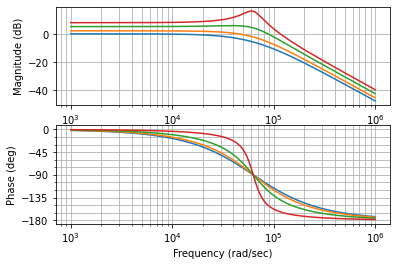

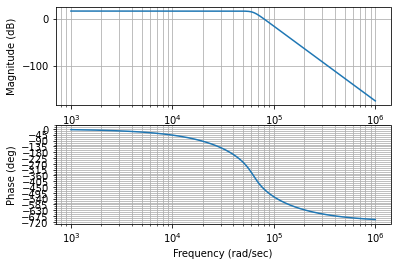

Equation 1:  
               2.578e+14
---------------------------------------
6.283e+04 s^2 + 7.741e+09 s + 2.481e+14

Equation 2:  
               3.314e+14
---------------------------------------
6.283e+04 s^2 + 6.569e+09 s + 2.481e+14

Equation 3:  
               4.685e+14
---------------------------------------
6.283e+04 s^2 + 4.386e+09 s + 2.481e+14

Equation 4:  
              6.474e+14
--------------------------------------
6.283e+04 s^2 + 1.54e+09 s + 2.481e+14

Pole 1:  [-61599.85595274+12381.41781208j -61599.85595274-12381.41781208j]
Pole 2:  [-52272.75629933+34862.59756969j -52272.75629933-34862.59756969j]
Pole 3:  [-34906.58503989+52243.39270462j -34906.58503989-52243.39270462j]
Pole 4:  [-12257.48206629+61624.63706855j -12257.48206629-61624.63706855j]
Zero 1:  []
Zero 2:  []
Zero 3:  []
Zero 4:  []


In [3]:
%matplotlib inline
componentVals = FilterCalculator.\
tableCalculation( DesignFrequency = 10000,   # Enter your design frequency
                  DecimalPlaceAccuracy = 2,  # The accuracy you want for your calculation, 0,1,2
                  Type = "butterworth",      # Types: chebyshev0_1; chebyshev1; butterworth, bessel
                  Response = "lowpass",      # Response: Highpass; Lowpass
                  Order = 8,                 # Order: 2,4,6,8,10
                  Tolerance = 0.05,          # Tolerance(R and C): 0.01 and 0.05
                  Graphing = True,           # Graphing: True; False
                  Equations = True,          # Equations: True; False
                  Poles = True,              # Poles: True; False
                  Zeros = True)              # Zeros: True; False

In [4]:
# If you need to adjust Gain
FilterCalculator.GainAdjuster(A_Old=2.609832227857979, A_New= 1, Resistor=330000) 

The value on R1_A:  861244.6351931331
The value on R1_B:  534990.3053805138


# Sallen-Key Unity Gain Designer

The functions below construct the spice files off a Unity Gain filter that can be used in LTSpice.

Note: The resulting filters were only verified in LTSpice and not in other SPICE programs.

In [5]:
class Filter_Builder:
    def SecondOrderUnityGain(self,mR1=0,R1=0,C1=0,nC1=0,minVolt=0,maxVolt=5):
        f = open("UnityGain2ndOrderFilter.asc", "w")
        f.write("Version 4\n")
        f.write("SHEET 1 1728 680\n")
        f.write("WIRE 496 64 288 64\n")
        f.write("WIRE 752 64 560 64\n")
        f.write("WIRE 160 224 80 224\n")
        f.write("WIRE 288 224 288 64\n")
        f.write("WIRE 288 224 240 224\n")
        f.write("WIRE 320 224 288 224\n")
        f.write("WIRE 416 224 400 224\n")
        f.write("WIRE 544 224 416 224\n")
        f.write("WIRE 752 240 752 64\n")
        f.write("WIRE 752 240 608 240\n")
        f.write("WIRE 416 256 416 224\n")
        f.write("WIRE 544 256 496 256\n")
        f.write("WIRE 80 368 80 224\n")
        f.write("WIRE 416 368 416 320\n")
        f.write("WIRE 496 384 496 256\n")
        f.write("WIRE 752 384 752 240\n")
        f.write("WIRE 752 384 496 384\n")
        f.write("WIRE 80 512 80 448\n")
        f.write("WIRE 720 624 720 576\n")
        f.write("FLAG 416 368 0\n")
        f.write("FLAG 720 624 0\n")
        f.write("FLAG 800 576 V_Pos\n")
        f.write("FLAG 640 576 V_Neg\n")
        f.write("FLAG 80 512 0\n")
        f.write("FLAG 576 272 V_Pos\n")
        f.write("FLAG 576 208 V_Neg\n")
        f.write("SYMBOL res 256 208 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR1\n")
        f.write("SYMATTR Value {}\n".format(mR1))
        f.write("SYMBOL res 416 208 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R1\n")
        f.write("SYMATTR Value {}\n".format(R1))
        f.write("SYMBOL cap 400 256 R0\n")
        f.write("SYMATTR InstName C1\n")
        f.write("SYMATTR Value {}\n".format(C1))
        f.write("SYMBOL cap 560 48 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC1\n")
        f.write("SYMATTR Value {}\n".format(nC1))
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMBOL voltage 816 576 R90\n")
        f.write("WINDOW 0 -32 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName V1\n")
        f.write("SYMATTR Value {}\n".format(maxVolt))
        f.write("SYMBOL voltage 624 576 R270\n")
        f.write("WINDOW 0 32 56 VTop 2\n")
        f.write("WINDOW 3 -32 56 VBottom 2\n")
        f.write("SYMATTR InstName V2\n")
        f.write("SYMATTR Value {}\n".format(minVolt))
        f.write("SYMBOL voltage 80 352 R0\n")
        f.write("WINDOW 123 0 0 Left 0\n")
        f.write("WINDOW 39 0 0 Left 0\n")
        f.write("SYMATTR InstName V3\n")
        f.write("SYMATTR Value ac\n")
        f.write("SYMBOL Opamps\\\LT1677 576 304 M180\n")
        f.write("SYMATTR InstName U1\n")
#         f.write("TEXT -160 480 Left 2 !.ac dec 1000 1 1000000")
        f.close()
        
    def FourthOrderUnityGain(self,mR1=0,R1=0,C1=0,nC1=0,mR2=0,R2=0,C2=0,nC2=0,minVolt=0,maxVolt=5):
        f = open("UnityGain4thOrderFilter.asc", "w")
        f.write("Version 4\n")
        f.write("SHEET 1 1728 680\n")
        f.write("WIRE 496 64 288 64\n")
        f.write("WIRE 752 64 560 64\n")
        f.write("WIRE 1088 64 896 64\n")
        f.write("WIRE 1408 64 1152 64\n")
        f.write("WIRE 160 224 80 224\n")
        f.write("WIRE 288 224 288 64\n")
        f.write("WIRE 288 224 240 224\n")
        f.write("WIRE 320 224 288 224\n")
        f.write("WIRE 416 224 400 224\n")
        f.write("WIRE 544 224 416 224\n")
        f.write("WIRE 752 240 752 64\n")
        f.write("WIRE 752 240 608 240\n")
        f.write("WIRE 800 240 752 240\n")
        f.write("WIRE 896 240 896 64\n")
        f.write("WIRE 896 240 880 240\n")
        f.write("WIRE 912 240 896 240\n")
        f.write("WIRE 1008 240 992 240\n")
        f.write("WIRE 1152 240 1008 240\n")
        f.write("WIRE 416 256 416 224\n")
        f.write("WIRE 544 256 496 256\n")
        f.write("WIRE 1408 256 1408 64\n")
        f.write("WIRE 1408 256 1216 256\n")
        f.write("WIRE 1152 272 1088 272\n")
        f.write("WIRE 1008 288 1008 240\n")
        f.write("WIRE 80 368 80 224\n")
        f.write("WIRE 416 368 416 320\n")
        f.write("WIRE 496 384 496 256\n")
        f.write("WIRE 752 384 752 240\n")
        f.write("WIRE 752 384 496 384\n")
        f.write("WIRE 1008 384 1008 352\n")
        f.write("WIRE 1088 384 1088 272\n")
        f.write("WIRE 1408 384 1408 256\n")
        f.write("WIRE 1408 384 1088 384\n")
        f.write("WIRE 80 512 80 448\n")
        f.write("WIRE 720 624 720 576\n")
        f.write("FLAG 416 368 0\n")
        f.write("FLAG 1008 384 0\n")
        f.write("FLAG 720 624 0\n")
        f.write("FLAG 800 576 V_Pos\n")
        f.write("FLAG 640 576 V_Neg\n")
        f.write("FLAG 80 512 0\n")
        f.write("FLAG 1184 288 V_Pos\n")
        f.write("FLAG 576 272 V_Pos\n")
        f.write("FLAG 576 208 V_Neg\n")
        f.write("FLAG 1184 224 V_Neg\n")
        f.write("SYMBOL res 256 208 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR1\n")
        f.write("SYMATTR Value {}\n".format(mR1))
        f.write("SYMBOL res 416 208 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R1\n")
        f.write("SYMATTR Value {}\n".format(R1))
        f.write("SYMBOL cap 400 256 R0\n")
        f.write("SYMATTR InstName C1\n")
        f.write("SYMATTR Value {}\n".format(C1))
        f.write("SYMBOL cap 560 48 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC1\n")
        f.write("SYMATTR Value {}\n".format(nC1))
        f.write("SYMBOL res 896 224 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR2\n")
        f.write("SYMATTR Value {}\n".format(mR2))
        f.write("SYMBOL res 1008 224 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R2\n")
        f.write("SYMATTR Value {}\n".format(R2))
        f.write("SYMBOL cap 1152 48 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC2\n")
        f.write("SYMATTR Value {}\n".format(nC2))
        f.write("SYMBOL cap 992 288 R0\n")
        f.write("SYMATTR InstName C2\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL voltage 816 576 R90\n")
        f.write("WINDOW 0 -32 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName V1\n")
        f.write("SYMATTR Value {}\n".format(maxVolt))
        f.write("SYMBOL voltage 624 576 R270\n")
        f.write("WINDOW 0 32 56 VTop 2\n")
        f.write("WINDOW 3 -32 56 VBottom 2\n")
        f.write("SYMATTR InstName V2\n")
        f.write("SYMATTR Value {}\n".format(minVolt))
        f.write("SYMBOL voltage 80 352 R0\n")
        f.write("WINDOW 123 0 0 Left 0\n")
        f.write("WINDOW 39 0 0 Left 0\n")
        f.write("SYMATTR InstName V3\n")
        f.write("SYMATTR Value ac\n")
        f.write("SYMBOL Opamps\\\LT1677 576 304 M180\n")
        f.write("SYMATTR InstName U1\n")
        f.write("SYMBOL Opamps\\\LT1677 1184 320 M180\n")
        f.write("SYMATTR InstName U2 ")
#         f.write("TEXT -160 480 Left 2 !.ac dec 1000 1 1000000")
        f.close()
    
    def SixthOrderUnityGain(self,mR1=0,R1=0,C1=0,nC1=0,mR2=0,R2=0,C2=0,nC2=0,mR3=0,R3=0,C3=0,nC3=0,minVolt=0,maxVolt=5):
        f = open("UnityGain6thOrderFilter.asc", "w")
        f.write("Version 4\n")
        f.write("SHEET 1 2600 680\n")
        f.write("WIRE 352 -80 160 -80\n")
        f.write("WIRE 608 -80 416 -80\n")
        f.write("WIRE 1024 -64 832 -64\n")
        f.write("WIRE 1280 -64 1088 -64\n")
        f.write("WIRE 1664 -48 1472 -48\n")
        f.write("WIRE 1920 -48 1728 -48\n")
        f.write("WIRE -32 64 -128 64\n")
        f.write("WIRE 160 64 160 -80\n")
        f.write("WIRE 160 64 48 64\n")
        f.write("WIRE 192 64 160 64\n")
        f.write("WIRE 304 64 272 64\n")
        f.write("WIRE 432 64 304 64\n")
        f.write("WIRE -128 80 -128 64\n")
        f.write("WIRE 608 80 608 -80\n")
        f.write("WIRE 608 80 496 80\n")
        f.write("WIRE 640 80 608 80\n")
        f.write("WIRE 832 80 832 -64\n")
        f.write("WIRE 832 80 720 80\n")
        f.write("WIRE 864 80 832 80\n")
        f.write("WIRE 976 80 944 80\n")
        f.write("WIRE 1104 80 976 80\n")
        f.write("WIRE 432 96 384 96\n")
        f.write("WIRE 1280 96 1280 -64\n")
        f.write("WIRE 1280 96 1168 96\n")
        f.write("WIRE 1328 96 1280 96\n")
        f.write("WIRE 1472 96 1472 -48\n")
        f.write("WIRE 1472 96 1408 96\n")
        f.write("WIRE 1504 96 1472 96\n")
        f.write("WIRE 1616 96 1584 96\n")
        f.write("WIRE 1744 96 1616 96\n")
        f.write("WIRE 304 112 304 64\n")
        f.write("WIRE 1104 112 1056 112\n")
        f.write("WIRE 1920 112 1920 -48\n")
        f.write("WIRE 1920 112 1808 112\n")
        f.write("WIRE 976 128 976 80\n")
        f.write("WIRE 1744 128 1696 128\n")
        f.write("WIRE 1616 144 1616 96\n")
        f.write("WIRE -128 208 -128 160\n")
        f.write("WIRE 304 208 304 176\n")
        f.write("WIRE 384 224 384 96\n")
        f.write("WIRE 608 224 608 80\n")
        f.write("WIRE 608 224 384 224\n")
        f.write("WIRE 976 224 976 192\n")
        f.write("WIRE 1056 240 1056 112\n")
        f.write("WIRE 1280 240 1280 96\n")
        f.write("WIRE 1280 240 1056 240\n")
        f.write("WIRE 1616 240 1616 208\n")
        f.write("WIRE 1696 256 1696 128\n")
        f.write("WIRE 1920 256 1920 112\n")
        f.write("WIRE 1920 256 1696 256\n")
        f.write("WIRE 224 448 224 416\n")
        f.write("FLAG 224 448 0\n")
        f.write("FLAG 304 416 V_Pos\n")
        f.write("FLAG 144 416 V_Neg\n")
        f.write("FLAG 304 208 0\n")
        f.write("FLAG -128 208 0\n")
        f.write("FLAG 464 112 V_Pos\n")
        f.write("FLAG 464 48 V_Neg\n")
        f.write("FLAG 976 224 0\n")
        f.write("FLAG 1136 128 V_Pos\n")
        f.write("FLAG 1136 64 V_Neg\n")
        f.write("FLAG 1616 240 0\n")
        f.write("FLAG 1776 144 V_Pos\n")
        f.write("FLAG 1776 80 V_Neg\n")
        f.write("SYMBOL voltage 320 416 R90\n")
        f.write("WINDOW 0 -32 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName V1\n")
        f.write("SYMATTR Value {}\n".format(maxVolt))
        f.write("SYMBOL voltage 128 416 R270\n")
        f.write("WINDOW 0 32 56 VTop 2\n")
        f.write("WINDOW 3 -32 56 VBottom 2\n")
        f.write("SYMATTR InstName V2\n")
        f.write("SYMATTR Value {}\n".format(minVolt))
        f.write("SYMBOL cap 288 112 R0\n")
        f.write("SYMATTR InstName C\n")
        f.write("SYMATTR Value {}\n".format(C1))
        f.write("SYMBOL res 288 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R\n")
        f.write("SYMATTR Value {}\n".format(R1))
        f.write("SYMBOL cap 416 -96 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC\n")
        f.write("SYMATTR Value {}\n".format(nC1))
        f.write("SYMBOL res 64 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR\n")
        f.write("SYMATTR Value {}\n".format(mR1))
        f.write("SYMBOL voltage -128 64 R0\n")
        f.write("WINDOW 123 0 0 Left 0\n")
        f.write("WINDOW 39 0 0 Left 0\n")
        f.write("WINDOW 3 25 91 Left 2\n")
        f.write("SYMATTR InstName V3\n")
        f.write("SYMATTR Value ac\n")
        f.write("SYMBOL Opamps\\\LT1677 464 144 M180\n")
        f.write("SYMATTR InstName U1\n")
        f.write("SYMBOL cap 960 128 R0\n")
        f.write("SYMATTR InstName C1\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 960 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R1\n")
        f.write("SYMATTR Value {}\n".format(R2))
        f.write("SYMBOL cap 1088 -80 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC1\n")
        f.write("SYMATTR Value {}\n".format(nC2))
        f.write("SYMBOL res 736 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR1\n")
        f.write("SYMATTR Value {}\n".format(mR2))
        f.write("SYMBOL Opamps\\\LT1677 1136 160 M180\n")
        f.write("SYMATTR InstName U2\n")
        f.write("SYMBOL cap 1600 144 R0\n")
        f.write("SYMATTR InstName C2\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 1600 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R2\n")
        f.write("SYMATTR Value {}\n".format(R3))
        f.write("SYMBOL cap 1728 -64 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC2\n")
        f.write("SYMATTR Value {}\n".format(nC3))
        f.write("SYMBOL res 1424 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 43 59 VTop 2\n")
        f.write("SYMATTR InstName mR2\n")
        f.write("SYMATTR Value {}\n".format(mR3))
        f.write("SYMBOL Opamps\\\LT1677 1776 176 M180\n")
        f.write("SYMATTR InstName U3\n")
#         f.write("TEXT -160 480 Left 2 !.ac dec 1000 1 1000000")
        f.close()
        
    def EighthOrderUnityGain(self,mR1=0,R1=0,C1=0,nC1=0,mR2=0,R2=0,C2=0,nC2=0,mR3=0,R3=0,C3=0,nC3=0,mR4=0,R4=0,C4=0,nC4=0,minVolt=0,maxVolt=5):
        f = open("UnityGain8thOrderFilter.asc", "w")
        f.write("Version 4\n")
        f.write("SHEET 1 2600 680\n")
        f.write("WIRE 352 -80 160 -80\n")
        f.write("WIRE 608 -80 416 -80\n")
        f.write("WIRE 1024 -64 832 -64\n")
        f.write("WIRE 1280 -64 1088 -64\n")
        f.write("WIRE 1664 -48 1472 -48\n")
        f.write("WIRE 1920 -48 1728 -48\n")
        f.write("WIRE 2336 -32 2144 -32\n")
        f.write("WIRE 2592 -32 2400 -32\n")
        f.write("WIRE -32 64 -128 64\n")
        f.write("WIRE 160 64 160 -80\n")
        f.write("WIRE 160 64 48 64\n")
        f.write("WIRE 192 64 160 64\n")
        f.write("WIRE 304 64 272 64\n")
        f.write("WIRE 432 64 304 64\n")
        f.write("WIRE -128 80 -128 64\n")
        f.write("WIRE 608 80 608 -80\n")
        f.write("WIRE 608 80 496 80\n")
        f.write("WIRE 640 80 608 80\n")
        f.write("WIRE 832 80 832 -64\n")
        f.write("WIRE 832 80 720 80\n")
        f.write("WIRE 864 80 832 80\n")
        f.write("WIRE 976 80 944 80\n")
        f.write("WIRE 1104 80 976 80\n")
        f.write("WIRE 432 96 384 96\n")
        f.write("WIRE 1280 96 1280 -64\n")
        f.write("WIRE 1280 96 1168 96\n")
        f.write("WIRE 1328 96 1280 96\n")
        f.write("WIRE 1472 96 1472 -48\n")
        f.write("WIRE 1472 96 1408 96\n")
        f.write("WIRE 1504 96 1472 96\n")
        f.write("WIRE 1616 96 1584 96\n")
        f.write("WIRE 1744 96 1616 96\n")
        f.write("WIRE 304 112 304 64\n")
        f.write("WIRE 1104 112 1056 112\n")
        f.write("WIRE 1920 112 1920 -48\n")
        f.write("WIRE 1920 112 1808 112\n")
        f.write("WIRE 2000 112 1920 112\n")
        f.write("WIRE 2144 112 2144 -32\n")
        f.write("WIRE 2144 112 2080 112\n")
        f.write("WIRE 2176 112 2144 112\n")
        f.write("WIRE 2288 112 2256 112\n")
        f.write("WIRE 2416 112 2288 112\n")
        f.write("WIRE 976 128 976 80\n")
        f.write("WIRE 1744 128 1696 128\n")
        f.write("WIRE 2592 128 2592 -32\n")
        f.write("WIRE 2592 128 2480 128\n")
        f.write("WIRE 1616 144 1616 96\n")
        f.write("WIRE 2416 144 2368 144\n")
        f.write("WIRE 2288 160 2288 112\n")
        f.write("WIRE -128 208 -128 160\n")
        f.write("WIRE 304 208 304 176\n")
        f.write("WIRE 384 224 384 96\n")
        f.write("WIRE 608 224 608 80\n")
        f.write("WIRE 608 224 384 224\n")
        f.write("WIRE 976 224 976 192\n")
        f.write("WIRE 1056 240 1056 112\n")
        f.write("WIRE 1280 240 1280 96\n")
        f.write("WIRE 1280 240 1056 240\n")
        f.write("WIRE 1616 240 1616 208\n")
        f.write("WIRE 1696 256 1696 128\n")
        f.write("WIRE 1920 256 1920 112\n")
        f.write("WIRE 1920 256 1696 256\n")
        f.write("WIRE 2288 256 2288 224\n")
        f.write("WIRE 2368 272 2368 144\n")
        f.write("WIRE 2592 272 2592 128\n")
        f.write("WIRE 2592 272 2368 272\n")
        f.write("WIRE 224 448 224 416\n")
        f.write("FLAG 224 448 0\n")
        f.write("FLAG 304 416 V_Pos\n")
        f.write("FLAG 144 416 V_Neg\n")
        f.write("FLAG 304 208 0\n")
        f.write("FLAG -128 208 0\n")
        f.write("FLAG 464 112 V_Pos\n")
        f.write("FLAG 464 48 V_Neg\n")
        f.write("FLAG 976 224 0\n")
        f.write("FLAG 1136 128 V_Pos\n")
        f.write("FLAG 1136 64 V_Neg\n")
        f.write("FLAG 1616 240 0\n")
        f.write("FLAG 1776 144 V_Pos\n")
        f.write("FLAG 1776 80 V_Neg\n")
        f.write("FLAG 2288 256 0\n")
        f.write("FLAG 2448 160 V_Pos\n")
        f.write("FLAG 2448 96 V_Neg\n")
        f.write("SYMBOL voltage 320 416 R90\n")
        f.write("WINDOW 0 -32 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName V1\n")
        f.write("SYMATTR Value {}\n".format(maxVolt))
        f.write("SYMBOL voltage 128 416 R270\n")
        f.write("WINDOW 0 32 56 VTop 2\n")
        f.write("WINDOW 3 -32 56 VBottom 2\n")
        f.write("SYMATTR InstName V2\n")
        f.write("SYMATTR Value {}\n".format(minVolt))
        f.write("SYMBOL cap 288 112 R0\n")
        f.write("SYMATTR InstName C\n")
        f.write("SYMATTR Value {}\n".format(C1))
        f.write("SYMBOL res 288 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R\n")
        f.write("SYMATTR Value {}\n".format(R1))
        f.write("SYMBOL cap 416 -96 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC\n")
        f.write("SYMATTR Value {}\n".format(nC1))
        f.write("SYMBOL res 64 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR\n")
        f.write("SYMATTR Value {}\n".format(mR1))
        f.write("SYMBOL voltage -128 64 R0\n")
        f.write("WINDOW 123 0 0 Left 0\n")
        f.write("WINDOW 39 0 0 Left 0\n")
        f.write("WINDOW 3 25 91 Left 2\n")
        f.write("SYMATTR InstName V3\n")
        f.write("SYMATTR Value ac\n")
        f.write("SYMBOL Opamps\\\LT1677 464 144 M180\n")
        f.write("SYMATTR InstName U1\n")
        f.write("SYMBOL cap 960 128 R0\n")
        f.write("SYMATTR InstName C1\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 960 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R1\n")
        f.write("SYMATTR Value {}\n".format(R2))
        f.write("SYMBOL cap 1088 -80 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC1\n")
        f.write("SYMATTR Value {}\n".format(nC2))
        f.write("SYMBOL res 736 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR1\n")
        f.write("SYMATTR Value {}\n".format(mR2))
        f.write("SYMBOL Opamps\\\LT1677 1136 160 M180\n")
        f.write("SYMATTR InstName U2\n")
        f.write("SYMBOL cap 1600 144 R0\n")
        f.write("SYMATTR InstName C2\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 1600 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R2\n")
        f.write("SYMATTR Value {}\n".format(R3))
        f.write("SYMBOL cap 1728 -64 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC2\n")
        f.write("SYMATTR Value {}\n".format(nC3))
        f.write("SYMBOL res 1424 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 43 59 VTop 2\n")
        f.write("SYMATTR InstName mR2\n")
        f.write("SYMATTR Value {}\n".format(mR3))
        f.write("SYMBOL Opamps\\\LT1677 1776 176 M180\n")
        f.write("SYMATTR InstName U3\n")
        f.write("SYMBOL cap 2272 160 R0\n")
        f.write("SYMATTR InstName C3\n")
        f.write("SYMATTR Value {}\n".format(C4))
        f.write("SYMBOL res 2272 96 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R3\n")
        f.write("SYMATTR Value {}\n".format(R4))
        f.write("SYMBOL cap 2400 -48 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC3\n")
        f.write("SYMATTR Value {}\n".format(nC4))
        f.write("SYMBOL res 2096 96 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR3\n")
        f.write("SYMATTR Value {}\n".format(mR4))
        f.write("SYMBOL Opamps\\\LT1677 2448 192 M180\n")
        f.write("SYMATTR InstName U4\n")
#         f.write("TEXT -160 480 Left 2 !.ac dec 1000 1 1000000")
        f.close()
    def TenthOrderUnityGain(self,mR1=0,R1=0,C1=0,nC1=0,mR2=0,R2=0,C2=0,nC2=0,mR3=0,R3=0,C3=0,nC3=0,mR4=0,R4=0,C4=0,nC4=0,mR5=0,R5=0,C5=0,nC5=0,minVolt=0,maxVolt=5):
        f = open("UnityGain10thOrderFilter.asc", "w")
        f.write("Version 4\n")
        f.write("SHEET 1 3272 680\n")
        f.write("WIRE 352 -80 160 -80\n")
        f.write("WIRE 608 -80 416 -80\n")
        f.write("WIRE 1024 -64 832 -64\n")
        f.write("WIRE 1280 -64 1088 -64\n")
        f.write("WIRE 1664 -48 1472 -48\n")
        f.write("WIRE 1920 -48 1728 -48\n")
        f.write("WIRE 2336 -32 2144 -32\n")
        f.write("WIRE 2592 -32 2400 -32\n")
        f.write("WIRE 3008 -16 2816 -16\n")
        f.write("WIRE 3264 -16 3072 -16\n")
        f.write("WIRE -32 64 -128 64\n")
        f.write("WIRE 160 64 160 -80\n")
        f.write("WIRE 160 64 48 64\n")
        f.write("WIRE 192 64 160 64\n")
        f.write("WIRE 304 64 272 64\n")
        f.write("WIRE 432 64 304 64\n")
        f.write("WIRE -128 80 -128 64\n")
        f.write("WIRE 608 80 608 -80\n")
        f.write("WIRE 608 80 496 80\n")
        f.write("WIRE 640 80 608 80\n")
        f.write("WIRE 832 80 832 -64\n")
        f.write("WIRE 832 80 720 80\n")
        f.write("WIRE 864 80 832 80\n")
        f.write("WIRE 976 80 944 80\n")
        f.write("WIRE 1104 80 976 80\n")
        f.write("WIRE 432 96 384 96\n")
        f.write("WIRE 1280 96 1280 -64\n")
        f.write("WIRE 1280 96 1168 96\n")
        f.write("WIRE 1328 96 1280 96\n")
        f.write("WIRE 1472 96 1472 -48\n")
        f.write("WIRE 1472 96 1408 96\n")
        f.write("WIRE 1504 96 1472 96\n")
        f.write("WIRE 1616 96 1584 96\n")
        f.write("WIRE 1744 96 1616 96\n")
        f.write("WIRE 304 112 304 64\n")
        f.write("WIRE 1104 112 1056 112\n")
        f.write("WIRE 1920 112 1920 -48\n")
        f.write("WIRE 1920 112 1808 112\n")
        f.write("WIRE 2000 112 1920 112\n")
        f.write("WIRE 2144 112 2144 -32\n")
        f.write("WIRE 2144 112 2080 112\n")
        f.write("WIRE 2176 112 2144 112\n")
        f.write("WIRE 2288 112 2256 112\n")
        f.write("WIRE 2416 112 2288 112\n")
        f.write("WIRE 976 128 976 80\n")
        f.write("WIRE 1744 128 1696 128\n")
        f.write("WIRE 2592 128 2592 -32\n")
        f.write("WIRE 2592 128 2480 128\n")
        f.write("WIRE 2672 128 2592 128\n")
        f.write("WIRE 2816 128 2816 -16\n")
        f.write("WIRE 2816 128 2752 128\n")
        f.write("WIRE 2848 128 2816 128\n")
        f.write("WIRE 2960 128 2928 128\n")
        f.write("WIRE 3088 128 2960 128\n")
        f.write("WIRE 1616 144 1616 96\n")
        f.write("WIRE 2416 144 2368 144\n")
        f.write("WIRE 3264 144 3264 -16\n")
        f.write("WIRE 3264 144 3152 144\n")
        f.write("WIRE 2288 160 2288 112\n")
        f.write("WIRE 3040 160 2960 160\n")
        f.write("WIRE 3088 160 3040 160\n")
        f.write("WIRE 2960 176 2960 160\n")
        f.write("WIRE -128 208 -128 160\n")
        f.write("WIRE 304 208 304 176\n")
        f.write("WIRE 384 224 384 96\n")
        f.write("WIRE 608 224 608 80\n")
        f.write("WIRE 608 224 384 224\n")
        f.write("WIRE 976 224 976 192\n")
        f.write("WIRE 1056 240 1056 112\n")
        f.write("WIRE 1280 240 1280 96\n")
        f.write("WIRE 1280 240 1056 240\n")
        f.write("WIRE 1616 240 1616 208\n")
        f.write("WIRE 1696 256 1696 128\n")
        f.write("WIRE 1920 256 1920 112\n")
        f.write("WIRE 1920 256 1696 256\n")
        f.write("WIRE 2288 256 2288 224\n")
        f.write("WIRE 2368 272 2368 144\n")
        f.write("WIRE 2592 272 2592 128\n")
        f.write("WIRE 2592 272 2368 272\n")
        f.write("WIRE 2960 272 2960 240\n")
        f.write("WIRE 3040 288 3040 160\n")
        f.write("WIRE 3264 288 3264 144\n")
        f.write("WIRE 3264 288 3040 288\n")
        f.write("WIRE 224 448 224 416\n")
        f.write("FLAG 224 448 0\n")
        f.write("FLAG 304 416 V_Pos\n")
        f.write("FLAG 144 416 V_Neg\n")
        f.write("FLAG 304 208 0\n")
        f.write("FLAG -128 208 0\n")
        f.write("FLAG 464 112 V_Pos\n")
        f.write("FLAG 464 48 V_Neg\n")
        f.write("FLAG 976 224 0\n")
        f.write("FLAG 1136 128 V_Pos\n")
        f.write("FLAG 1136 64 V_Neg\n")
        f.write("FLAG 1616 240 0\n")
        f.write("FLAG 1776 144 V_Pos\n")
        f.write("FLAG 1776 80 V_Neg\n")
        f.write("FLAG 2288 256 0\n")
        f.write("FLAG 2448 160 V_Pos\n")
        f.write("FLAG 2448 96 V_Neg\n")
        f.write("FLAG 2960 272 0\n")
        f.write("FLAG 3120 176 V_Pos\n")
        f.write("FLAG 3120 112 V_Neg\n")
        f.write("SYMBOL voltage 320 416 R90\n")
        f.write("WINDOW 0 -32 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName V1\n")
        f.write("SYMATTR Value {}\n".format(maxVolt))
        f.write("SYMBOL voltage 128 416 R270\n")
        f.write("WINDOW 0 32 56 VTop 2\n")
        f.write("WINDOW 3 -32 56 VBottom 2\n")
        f.write("SYMATTR InstName V2\n")
        f.write("SYMATTR Value {}\n".format(minVolt))
        f.write("SYMBOL cap 288 112 R0\n")
        f.write("SYMATTR InstName C\n")
        f.write("SYMATTR Value {}\n".format(C1))
        f.write("SYMBOL res 288 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R\n")
        f.write("SYMATTR Value {}\n".format(R1))
        f.write("SYMBOL cap 416 -96 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC\n")
        f.write("SYMATTR Value {}\n".format(nC1))
        f.write("SYMBOL res 64 48 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR\n")
        f.write("SYMATTR Value {}\n".format(mR1))
        f.write("SYMBOL voltage -128 64 R0\n")
        f.write("WINDOW 123 0 0 Left 0\n")
        f.write("WINDOW 39 0 0 Left 0\n")
        f.write("WINDOW 3 25 91 Left 2\n")
        f.write("SYMATTR InstName V3\n")
        f.write("SYMATTR Value ac\n")
        f.write("SYMBOL Opamps\\\LT1677 464 144 M180\n")
        f.write("SYMATTR InstName U1\n")
        f.write("SYMBOL cap 960 128 R0\n")
        f.write("SYMATTR InstName C1\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 960 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R1\n")
        f.write("SYMATTR Value {}\n".format(R2))
        f.write("SYMBOL cap 1088 -80 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC1\n")
        f.write("SYMATTR Value {}\n".format(nC2))
        f.write("SYMBOL res 736 64 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR1\n")
        f.write("SYMATTR Value {}\n".format(mR2))
        f.write("SYMBOL Opamps\\\LT1677 1136 160 M180\n")
        f.write("SYMATTR InstName U2\n")
        f.write("SYMBOL cap 1600 144 R0\n")
        f.write("SYMATTR InstName C2\n")
        f.write("SYMATTR Value {}\n".format(C2))
        f.write("SYMBOL res 1600 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R2\n")
        f.write("SYMATTR Value {}\n".format(R3))
        f.write("SYMBOL cap 1728 -64 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC2\n")
        f.write("SYMATTR Value {}\n".format(nC3))
        f.write("SYMBOL res 1424 80 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 43 59 VTop 2\n")
        f.write("SYMATTR InstName mR2\n")
        f.write("SYMATTR Value {}\n".format(mR3))
        f.write("SYMBOL Opamps\\\LT1677 1776 176 M180\n")
        f.write("SYMATTR InstName U3\n")
        f.write("SYMBOL cap 2272 160 R0\n")
        f.write("SYMATTR InstName C3\n")
        f.write("SYMATTR Value {}\n".format(C4))
        f.write("SYMBOL res 2272 96 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R3\n")
        f.write("SYMATTR Value {}\n".format(R4))
        f.write("SYMBOL cap 2400 -48 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC3\n")
        f.write("SYMATTR Value {}\n".format(nC4))
        f.write("SYMBOL res 2096 96 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR3\n")
        f.write("SYMATTR Value {}\n".format(mR4))
        f.write("SYMBOL Opamps\\\LT1677 2448 192 M180\n")
        f.write("SYMATTR InstName U4\n")
        f.write("SYMBOL cap 2944 176 R0\n")
        f.write("SYMATTR InstName C4\n")
        f.write("SYMATTR Value {}\n".format(C5))
        f.write("SYMBOL res 2944 112 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName R4\n")
        f.write("SYMATTR Value {}\n".format(R5))
        f.write("SYMBOL cap 3072 -32 R90\n")
        f.write("WINDOW 0 0 32 VBottom 2\n")
        f.write("WINDOW 3 32 32 VTop 2\n")
        f.write("SYMATTR InstName nC4\n")
        f.write("SYMATTR Value {}\n".format(nC4))
        f.write("SYMBOL res 2768 112 R90\n")
        f.write("WINDOW 0 0 56 VBottom 2\n")
        f.write("WINDOW 3 32 56 VTop 2\n")
        f.write("SYMATTR InstName mR4\n")
        f.write("SYMATTR Value {}\n".format(mR5))
        f.write("SYMBOL Opamps\\\LT1677 3120 208 M180\n")
        f.write("SYMATTR InstName U5\n")
#         f.write("TEXT -160 480 Left 2 !.ac dec 1000 1 1000000")
        f.close()

In [6]:
# Constructing a dummy file with uninitialized components
Filter_Builder().EighthOrderUnityGain(mR1=0,
                                         R1=0,
                                         C1=0,
                                         nC1=0,

                                         mR2=0,
                                         R2=0,
                                         C2=0,
                                         nC2=0,

                                         mR3=0,
                                         R3=0,
                                         C3=0,
                                         nC3=0,

                                         mR4=0,
                                         R4=0,
                                         C4=0,
                                         nC4=0,

                                         minVolt=0,
                                         maxVolt=5)

## Unity Gain Filter Calculator

In [7]:
class UnityGainFilterCalculator:
    def __init__(self):
        pass
    
    def tableCalculation(DesignFrequency, DecimalPlaceAccuracy, Type, Response, Order, Tolerance, Graphing = False, Equations = False, Poles = False, Zeros = False, min_voltage = 0, max_voltage = 5):
        """
        A function that calculates the resulting filter response and other parameters* using Sallen-Key Unity gain design
        according to [1] for the desired frequency, type and response.
        An optimisation function determines the best practical resistor value based on the amount of error it will cause in the physical circuit. The capacitors are not optimal values.
        
        Parameters:
        -----------
        DesignFrequency: int or float, required
           The desired design frequency in Hz
        
        DecimalPlaceAccuracy: int
            How accurate the mathematical calculations should be. 
                Bug: Error will occur when the decimal accuracy is too large because it cannot find a solution
        
        Type: str, required
            The type of filter to be implemented (chebyshev0_1; chebyshev1; butterworth; bessel)
                Note: Chebyshev0_1 - Type 1 
                      Chebyshev1 - Type 2
                      
        Response: str, required
            High pass or Low pass filter
        
        Order: int, required
            The order of the filter to be implemented (2, 4, 6, 8, 10)
        
        Tolerance: int, required
            The amount of resistor tolerance allowed in a design (1%, 5% and 10%)
        
        Graphing: bool, optional
            Plots the response of the graphs in the cascaded stages
            
        Equations: bool, optional
            Control library calculates and displays the transfer function of the filter
        
        Poles: bool, optional
            Control library calculates the poles of the system 
        
        Zeros: bool, optional
            Control library calculates the zeros of the system
        
        min_voltage: int, optional
            The voltage that will be input to the negative terminal of the opamp
        
        max_voltage:
            The voltage that will be input to the positive terminal of the opamp
            
        """ 
        # NOTE: These are restriction parameters that can be used to limit allowable component values
        capacitance_lower = (2.2 * (10 ** -12))
        capacitance_upper = (1 * (10 ** -4))
        resistance_lower = (1* (10 ** 2))
        resistance_upper = (2.7 * (10 ** 7))
        
        
        # design frequency
        fc = DesignFrequency
        
        r_percentage0 = 1
        r_percentage1 = 1
        r_percentage2 = 1
        r_percentage3 = 1
        r_percentage4 = 1
        
        w_0_0 = 0
        Q_0_0 = 0
        w_0_1 = 0
        Q_0_1 = 0
        w_0_2 = 0
        Q_0_2 = 0
        w_0_3 = 0
        Q_0_3 = 0
        w_0_4 = 0
        Q_0_4 = 0

        store0 = []
        store1 = []
        store2 = []
        store3 = []
        store4 = []

        gain = []
        
        #Percentage tolerance
        
        def RandCVals(tolerance):
            #1 percent
            if (tolerance == 0.01):
                ce12 = [[
                        100,102,105,107,110,113,115,118,121,124,127,130,133,137,140,143,147,150,154,158,162,165,169,174,
                        178,182,187,191,196,200,205,210,215,221,226,232,237,243,249,255,261,267,274,280,287,294,301,309,
                        316,324,332,340,348,357,365,374,383,392,402,412,422,432,442,453,464,475,487,499,511,523,536,549,
                        562,576,590,604,619,634,649,665,681,698,715,732,750,768,787,806,825,845,866,887,909,931,953,976
                        ],[10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 = [[
                        100,102,105,107,110,113,115,118,121,124,127,130,133,137,140,143,147,150,154,158,162,165,169,174,
                        178,182,187,191,196,200,205,210,215,221,226,232,237,243,249,255,261,267,274,280,287,294,301,309,
                        316,324,332,340,348,357,365,374,383,392,402,412,422,432,442,453,464,475,487,499,511,523,536,549,
                        562,576,590,604,619,634,649,665,681,698,715,732,750,768,787,806,825,845,866,887,909,931,953,976]
                        ,[10**(1), 10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            #5 percent
            elif (tolerance == 0.05):
                ce12 = [[10, 12, 15, 18, 22, 27, 33, 39, 47, 56, 68, 82],
                         [10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 =  [[10, 12, 15, 18, 22, 27, 33, 39, 47, 56, 68, 82], 
                        [10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            #10 percent
            elif (tolerance == 0.1):
                ce12 = [[10, 15, 22, 33, 47, 68],
                         [10 ** (-12), 10 ** (-11), 10 ** (-10), 10 ** (-9), 10 ** (-8), 10 ** (-7), 10 ** (-13)]]
                re6 = [[10, 15, 22, 33, 47, 68], 
                        [10 ** (2), 10 ** (3), 10 ** (4), 10 ** (5), 10 ** (6)]]
            return ce12, re6
        
                           
        c_e12, r_e6 = RandCVals(Tolerance)
        
        
        # Change these values depending on the table
        # Butterworth
        if (Order == 2) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1]
            Q_0_table = [0.707]
    
        elif (Order == 4) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1]
            Q_0_table = [0.541, 1.306]
    
        elif (Order == 6) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1]
            Q_0_table = [0.518, 0.707, 1.932]
        
        elif (Order == 8) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1,1]
            Q_0_table = [0.510,0.601,0.900,2.563]
        
        elif (Order == 10) and (str.upper(Type) == "BUTTERWORTH"):
            f_0_table = [1,1,1,1,1]
            Q_0_table = [0.506,0.561,0.707,1.101,3.196]
    
        # Bessel
        elif (Order == 2) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.274]
            Q_0_table = [0.577]
    
        elif (Order == 4) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.419,1.591]
            Q_0_table = [0.522,0.806]
    
        elif (Order == 6) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.606,1.691,1.907]
            Q_0_table = [0.510,0.611,1.023]
        
        elif (Order == 8) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.784,1.838,1.958,2.196]
            Q_0_table = [0.506,0.560,0.711,1.226]
        
        elif (Order == 10) and (str.upper(Type) == "BESSEL"):
            f_0_table = [1.949,1.987,2.068,2.211,2.485]
            Q_0_table = [0.504,0.538,0.620,0.810,1.415]

        # 0.1dB Ripple
        elif (Order == 2) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.820]
            Q_0_table = [0.767]
        
        elif (Order == 4) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.153,0.789]
            Q_0_table = [2.183,0.619]
            
        elif (Order == 6) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.063,0.834,0.513]
            Q_0_table = [4.633,1.332,0.599]
        
        elif (Order == 8) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.034,0.894,0.645,0.382]
            Q_0_table = [8.082,2.453,1.183,0.593]
        
        elif (Order == 10) and (str.upper(Type) == "CHEBYSHEV0_1"):
            f_0_table = [1.022,0.928,0.754,0.524,0.304]
            Q_0_table = [12.522,3.921,2.044,1.127,0.590]
         
        # 1dB Ripple
        elif (Order == 2) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [1.050]
            Q_0_table = [0.957]
        
        elif (Order == 4) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.993,0.529]
            Q_0_table = [3.559,0.785]
            
        elif (Order == 6) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.995,0.747,0.353]
            Q_0_table = [8.004,2.198,0.761]
        
        elif (Order == 8) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.997,0.851,0.584,0.265]
            Q_0_table = [14.240,4.266,1.956,0.753]
            
        elif (Order == 10) and (str.upper(Type) == "CHEBYSHEV1"):
            f_0_table = [0.998,0.902,0.721,0.476,0.212]
            Q_0_table = [22.263,6.937,3.561,1.864,0.749]
            
        #Design method
        
        if (str.upper(Response) == "LOWPASS"):
            def h_lpf_calculations(val, f_c, f_table, c, q):
                f0 = f_c * f_table
                
                w0 = 2 * np.pi * f0
                
                n = 4*q**2

                k = n/(2*q**2) - 1

                m = k+np.sqrt(k**2-1)

                r = 1/(np.sqrt(m*n)*(w0)*c)

                nC = n*c

                mR = m*r
                
                k = 1 #just being cheeky here
                
                return f_c, f0, q, w0, c, k, r, mR, nC
        

        
        #re6 is the main priority 
        nearestRarray = []
        for l in range(0, len(r_e6[0])):
            for m in range(0, len(r_e6[1])):
                if (r_e6[0][l] * r_e6[1][m] <= resistance_upper and (r_e6[0][l] * r_e6[1][m] >= resistance_lower)):
                    nearestRarray.append(r_e6[0][l] * r_e6[1][m])
        
        i = 0
        j = 0
        k = 0
        
        for k in range(0, len(f_0_table)):
            for i in range(0, len(c_e12[0])):
                for j in range(0, len(c_e12[1])):
                    if ((c_e12[1][j] * c_e12[0][i]) >= capacitance_lower and (c_e12[0][j] * c_e12[1][j]) <= capacitance_upper):
                        for l in range(0, len(r_e6[0])):
                            for m in range(0, len(r_e6[1])):
                                if (r_e6[0][l] * r_e6[1][m] <= resistance_upper and (r_e6[0][l] * r_e6[1][m] >= resistance_lower)):

                                    F_c, F0, Q, W, C, K, R, mR,nC  = h_lpf_calculations(k, fc, f_0_table[k],(c_e12[1][j] * c_e12[0][i]),Q_0_table[k])
                                    
                                    # Second Order
                                    if (Order >= 2):
                                        if ((k == 0) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage0) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage0 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store0.clear()
                                            store0 = [F_c, F0, Q, W, C, K, R, mR,nC]
                                            
                                    # Fourth Order
                                    if (Order >= 4):
                                        if ((k == 1) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage1) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage1 =   round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store1.clear()
                                            store1 = [F_c, F0, Q, W, C, K, R, mR,nC]
                                    
                                    # Sixth Order
                                    if (Order >= 6):
                                        if ((k == 2) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage2) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage2 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy )
                                            store2.clear()
                                            store2 = [F_c, F0, Q, W, C, K, R, mR,nC]

                                    # Eighth Order
                                    if (Order >= 8):
                                        if ((k == 3) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage3) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage3 =  round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) 
                                            store3.clear()
                                            store3 = [F_c, F0, Q, W, C, K, R, mR,nC]
                                    
                                    # Tenth Order
                                    if (Order >= 10):
                                        if ((k == 4) and ( round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) == r_percentage4) and (R >= resistance_lower and R <= resistance_upper)):
                                            r_percentage4 = round( ((r_e6[0][l] * r_e6[1][m])-R) / (r_e6[0][l] * r_e6[1][m]) , DecimalPlaceAccuracy ) 
                                            store4.clear()
                                            store4 = [F_c, F0, Q, W, C, K, R, mR,nC]
        
        def print_values(count, arr, resp, typ, nearArr):
            #Find the nearest real value array
            def find_nearest(arrIn, value):
                arrIn = np.asarray(arrIn)
                idx = (np.abs(arrIn - value)).argmin()
                return arrIn[idx]
            
            print('--------------------------------- \n')
            if count==0:
                print(resp)    
                print(typ)
            print('F0:' + str(count) + '\n')
            print('Natural frequency(f_0):' + str(arr[0]) + '\n')
            print('Cut off frequency(f_c):' + str(arr[1]) + '\n')
            print('Angular Frequency(w_o):' + str(arr[3]) + '\n')
            print('Quality Factor(Q):' + str(arr[2]) + '\n')
            print('Capacitance value chosen:' + str(arr[4]) + '\n')
            print('Gain:' + str(arr[5]) + '\n')
            print('Resitance(R):' + str(arr[6]) + ' /Practical Value: ' + str(find_nearest(nearArr,arr[6])) +'\n')
            print('mR:' + str(arr[7]) + ' /Practical Value: ' + str(find_nearest(nearArr,arr[7])) +'\n')
            print('nC:' + str(arr[8]) + '\n')
            print('---------------------------------' + '\n')
            print('\n')
        
        #Find the nearest real value array
        def find_nearest_prac(arrIn, value): #my apologies for this
            arrIn = np.asarray(arrIn)
            idx = (np.abs(arrIn - value)).argmin()
            return arrIn[idx]
        
        # Print the values
        if (Order >= 2):
            print_values(0, store0, str.upper(Response), str.upper(Type), nearestRarray)
            gain.append(store0[5])
            if (Order == 2):
                Filter_Builder().SecondOrderUnityGain(mR1=find_nearest_prac(nearestRarray,store0[7]),
                                                      R1=find_nearest_prac(nearestRarray,store0[6]),
                                                      C1=store0[4],
                                                      nC1=store0[8],
                                                      minVolt = min_voltage,
                                                      maxVolt = max_voltage)            

            
        if (Order >= 4):
            print_values(1, store1, str.upper(Response), str.upper(Type), nearestRarray)
            gain.append(store1[5])
            if (Order == 4):
                Filter_Builder().FourthOrderUnityGain(mR1=find_nearest_prac(nearestRarray,store0[7]),
                                                      R1=find_nearest_prac(nearestRarray,store0[6]),
                                                      C1=store0[4],
                                                      nC1=store0[8],
                                                      mR2=find_nearest_prac(nearestRarray,store1[7]),
                                                      R2=find_nearest_prac(nearestRarray,store1[6]),
                                                      C2=store1[4],
                                                      nC2=store1[8],
                                                      minVolt = min_voltage,
                                                      maxVolt = max_voltage)            

        if (Order >= 6):
            print_values(2, store2, str.upper(Response), str.upper(Type), nearestRarray)
            gain.append(store2[5])
            if (Order == 6):
                Filter_Builder().SixthOrderUnityGain(mR1=find_nearest_prac(nearestRarray,store0[7]),
                                                      R1=find_nearest_prac(nearestRarray,store0[6]),
                                                      C1=store0[4],
                                                      nC1=store0[8],
                                                      mR2=find_nearest_prac(nearestRarray,store1[7]),
                                                      R2=find_nearest_prac(nearestRarray,store1[6]),
                                                      C2=store1[4],
                                                      nC2=store1[8],
                                                      mR3=find_nearest_prac(nearestRarray,store2[7]),
                                                      R3=find_nearest_prac(nearestRarray,store2[6]),
                                                      C3=store2[4],
                                                      nC3=store2[8],
                                                      minVolt = min_voltage,
                                                      maxVolt = max_voltage)            

                
        if (Order >= 8):
            print_values(3, store3, str.upper(Response), str.upper(Type), nearestRarray)
            gain.append(store3[5])
            if (Order == 8):
                Filter_Builder().EighthOrderUnityGain(mR1=find_nearest_prac(nearestRarray,store0[7]),
                                                      R1=find_nearest_prac(nearestRarray,store0[6]),
                                                      C1=store0[4],
                                                      nC1=store0[8],
                                                      mR2=find_nearest_prac(nearestRarray,store1[7]),
                                                      R2=find_nearest_prac(nearestRarray,store1[6]),
                                                      C2=store1[4],
                                                      nC2=store1[8],
                                                      mR3=find_nearest_prac(nearestRarray,store2[7]),
                                                      R3=find_nearest_prac(nearestRarray,store2[6]),
                                                      C3=store2[4],
                                                      nC3=store2[8],
                                                      mR4=find_nearest_prac(nearestRarray,store3[7]),
                                                      R4=find_nearest_prac(nearestRarray,store3[6]),
                                                      C4=store3[4],
                                                      nC4=store3[8],
                                                      minVolt = min_voltage,
                                                      maxVolt = max_voltage)            

        if (Order >= 10):           
            print_values(4, store4, str.upper(Response), str.upper(Type), nearestRarray)
            gain.append(store4[5])
            if (Order == 10):
                Filter_Builder().TenthOrderUnityGain(mR1=find_nearest_prac(nearestRarray,store0[7]),
                                                      R1=find_nearest_prac(nearestRarray,store0[6]),
                                                      C1=store0[4],
                                                      nC1=store0[8],
                                                      mR2=find_nearest_prac(nearestRarray,store1[7]),
                                                      R2=find_nearest_prac(nearestRarray,store1[6]),
                                                      C2=store1[4],
                                                      nC2=store1[8],
                                                      mR3=find_nearest_prac(nearestRarray,store2[7]),
                                                      R3=find_nearest_prac(nearestRarray,store2[6]),
                                                      C3=store2[4],
                                                      nC3=store2[8],
                                                      mR4=find_nearest_prac(nearestRarray,store3[7]),
                                                      R4=find_nearest_prac(nearestRarray,store3[6]),
                                                      C4=store3[4],
                                                      nC4=store3[8],
                                                      mR5=find_nearest_prac(nearestRarray,store4[7]),
                                                      R5=find_nearest_prac(nearestRarray,store4[6]),
                                                      C5=store4[4],
                                                      nC5=store4[8],
                                                      minVolt = min_voltage,
                                                      maxVolt = max_voltage)   
            
        # Graphing    
        if (Graphing == True):
            
            s = ml.tf('s')
            
            if (Order>=2):
                w_0_0 = (store0[3])
                Q_0_0 = 1/store0[2]
            if (Order>=4):
                w_0_1 = (store1[3])
                Q_0_1 = 1/store1[2]
            if (Order>=6):
                w_0_2 = (store2[3])
                Q_0_2 = 1/store2[2]
            if (Order>=8):
                w_0_3 = (store3[3])
                Q_0_3 = 1/store3[2]
            if (Order>=10):
                w_0_4 = (store4[3])
                Q_0_4 = 1/store4[2]
                
            if (str.upper(Response) == "LOWPASS"):
                
                if (Order>=2):
                    H  = gain[0]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_0 ) **2 ) + ( s *Q_0_0 ) / w_0_0 ) )
                    mag, phase, w = ml.bode(H)
                    Z = H
                if (Order>=4):
                    G = gain[1]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_1 ) **2 ) + ( s *Q_0_1 ) / w_0_1 ) )
                    mag1, phase1, w1 = ml.bode(G)
                    Z = H*G
                if (Order>=6):
                    M = gain[2]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_2 ) **2 ) + ( s *Q_0_2 ) / w_0_2 ) )
                    mag2, phase2, w2 = ml.bode(M)
                    Z = H*G*M
                if (Order>=8):
                    N = gain[3]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_3 ) **2 ) + ( s *Q_0_3 ) / w_0_3 ) )
                    mag3, phase3, w3 = ml.bode(N)
                    Z = H*G*M*N
                if (Order>=10):
                    O = gain[3]*( 1 / ( 1 + ( ( s ) **2 ) / ( ( w_0_4 ) **2 ) + ( s *Q_0_4 ) / w_0_4 ) )
                    mag4, phase4, w4 = ml.bode(O)
                    Z = H*G*M*N*O
                    
                plt.show()
                
                magNew,phaseNewe,wNew = ml.bode(Z)
                plt.show()
                
            elif (str.upper(Response) == "HIGHPASS"):
                
                if (Order>=2):
                    H  = gain[0]*( ( (s / w_0_0 ) **2 ) / ( 1 + ( ( s ) **2 ) / ( ( w_0_0 ) **2 ) + ( s *Q_0_0 ) / w_0_0 ) )
                    mag, phase, w = ml.bode(H)
                    Z = H
                if (Order>=4):
                    G = gain[1]*( ( (s / w_0_1 ) **2 ) / ( 1 + ( ( s ) **2 ) / ( ( w_0_1 ) **2 ) + ( s *Q_0_1 ) / w_0_1 ) )
                    mag1, phase1, w1 = ml.bode(G)
                    Z = H*G
                if (Order>=6):
                    M = gain[2]*( ( (s / w_0_2 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_2 ) **2 ) + ( s *Q_0_2 ) / w_0_2 ) )
                    mag2, phase2, w2 = ml.bode(M)
                    Z = H*G*M
                if (Order>=8):
                    N = gain[3]*( ( (s / w_0_3 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_3 ) **2 ) + ( s *Q_0_3 ) / w_0_3 ) )
                    mag3, phase3, w3 = ml.bode(N)
                    Z = H*G*M*N
                if (Order>=10):
                    O = gain[3]*( ( (s / w_0_4 ) **2 )/ ( 1 + ( ( s ) **2 ) / ( ( w_0_4 ) **2 ) + ( s *Q_0_4 ) / w_0_4 ) )
                    mag4, phase4, w4 = ml.bode(O)
                    Z = H*G*M*N*O
                    
                plt.show()
                
                magNew, phaseNewe, wNew = ml.bode(Z)
                plt.show()
                
                    
            if (Equations == True):
                if (Order>=2):
                    print("Equation 1: ",H)
                if  (Order>=4):
                    print("Equation 2: ",G)
                if (Order>=6):
                    print("Equation 3: ",M)
                if (Order>=8):
                    print("Equation 4: ",N)
                if (Order>=10):
                    print("Equation 5: ",O)

            if (Poles == True):
                if (Order>=2):
                    print("Pole 1: ",ml.pole(H))
                if  (Order>=4):
                    print("Pole 2: ",ml.pole(G))
                if (Order>=6):
                    print("Pole 3: ",ml.pole(M))
                if (Order>=8):
                    print("Pole 4: ",ml.pole(N))
                if (Order>=10):
                    print("Pole 5: ",ml.pole(O))
                
            if (Zeros == True):
                if (Order>=2):
                    print("Zero 1: ",ml.zero(H))
                if (Order>=4):
                    print("Zero 2: ",ml.zero(G))
                if (Order>=6):
                    print("Zero 3: ",ml.zero(M))
                if (Order>=8):
                    print("Zero 4: ",ml.zero(N))
                if (Order>=10):
                    print("Zero 5: ",ml.zero(O))
              
            
    #=========================================================================================#
    def GainAdjuster(A_Old, A_New, Resistor):
        R1=Resistor
        R1_A=R1*(A_Old/A_New)
        R1_B=R1/(1-A_New/A_Old)
        print("The value on R1_A: ",R1_A)
        print("The value on R1_B: ",R1_B)

--------------------------------- 

LOWPASS
BUTTERWORTH
F0:0

Natural frequency(f_0):17000

Cut off frequency(f_c):17000

Angular Frequency(w_o):106814.15022205297

Quality Factor(Q):0.541

Capacitance value chosen:9.76e-11

Gain:1

Resitance(R):88653.14191230798 /Practical Value: 88700

mR:88653.14191230798 /Practical Value: 88700

nC:1.1426266240000001e-10

---------------------------------



--------------------------------- 

F0:1

Natural frequency(f_0):17000

Cut off frequency(f_c):17000

Angular Frequency(w_o):106814.15022205297

Quality Factor(Q):1.306

Capacitance value chosen:9.76e-11

Gain:1

Resitance(R):36723.85128220415 /Practical Value: 36500

mR:36723.85128220415 /Practical Value: 36500

nC:6.658802944e-10

---------------------------------





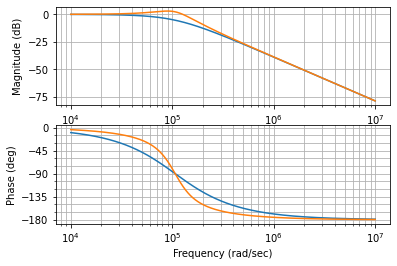

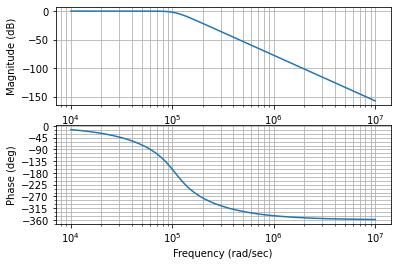

Equation 1:  
               1.219e+15
---------------------------------------
1.068e+05 s^2 + 2.109e+10 s + 1.219e+15

Equation 2:  
               1.219e+15
---------------------------------------
1.068e+05 s^2 + 8.736e+09 s + 1.219e+15



In [8]:
%matplotlib inline
UnityGainFilterCalculator.\
tableCalculation(DesignFrequency = 17000,    # Enter your design frequency
                  DecimalPlaceAccuracy = 0,  # The accuracy you want for your calculation, 0,1,2
                  Type = "butterworth",      # Types: chebyshev0_1; chebyshev1; butterworth; bessel
                  Response = "lowpass",      # Response: Highpass; Lowpass
                  Order = 4,                 # Order: 2,4,6,8,10
                  Tolerance = 0.01,          # Tolerance(R and C): 0.01 and 0.05
                  Graphing = True,           # Graphing: True; False
                  Equations = True,          # Equations: True; False
                  Poles = False,             # Poles: True; False
                  Zeros = False,             # Zeros: True; False
                  min_voltage = 0,
                  max_voltage = 5)           # Voltage: min; max

After running the above code, check your current working directory to view the ".asc" file. The file will contained the filter with practical values for the resistors. The user must then select run in order to run the simualtion of choice.

If then user wants to verify their design they should select the AC Analysis and then input their parameters of interest.

# References

[ 1 ] Franco, Sergio. Design with Operational Amplifiers and Analog Integrated Circuits. Fourth edition, McGraw-Hill Education, 2015.